In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
mean = np.array([0, 0, 0])
std = np.array([1, 1, 1])
rho_xy = 0.5
rho_xz = -0.3
rho_yz = 0.2
corr = np.array([
    [1, rho_xy, rho_xz],
    [rho_xy, 1, rho_yz],
    [rho_xz, rho_yz, 1],
])
cov = corr * np.outer(std, std)

In [4]:
cov

array([[ 1. ,  0.5, -0.3],
       [ 0.5,  1. ,  0.2],
       [-0.3,  0.2,  1. ]])

In [5]:
N = 1000

data = pd.DataFrame(scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=N), columns=["x", "y", "z"])

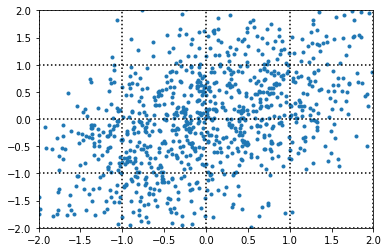

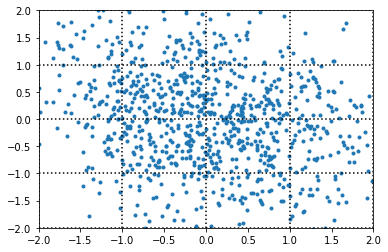

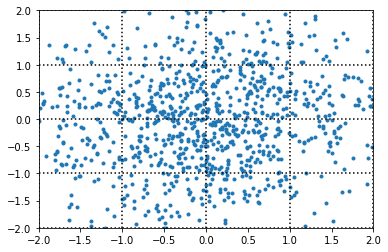

In [6]:
xbins = np.linspace(-2, 2, 5)
ybins = np.linspace(-2, 2, 5)
zbins = np.linspace(-2, 2, 5)
xlim = (min(xbins), max(xbins))
ylim = (min(ybins), max(ybins))
zlim = (min(zbins), max(zbins))

plt.scatter(data.x, data.y, marker=".")
for x in xbins:
    plt.axvline(x, color="black", ls=":")
for y in ybins:
    plt.axhline(y, color="black", ls=":")
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()
plt.close()


plt.scatter(data.x, data.z, marker=".")
for x in xbins:
    plt.axvline(x, color="black", ls=":")
for z in zbins:
    plt.axhline(z, color="black", ls=":")
plt.xlim(*xlim)
plt.ylim(*zlim)
plt.show()
plt.close()

plt.scatter(data.y, data.z, marker=".")
for y in ybins:
    plt.axvline(y, color="black", ls=":")
for z in zbins:
    plt.axhline(z, color="black", ls=":")
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()
plt.close()

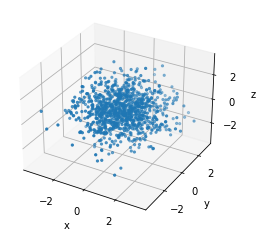

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data.values.transpose()[:50], marker='.')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
plt.close()

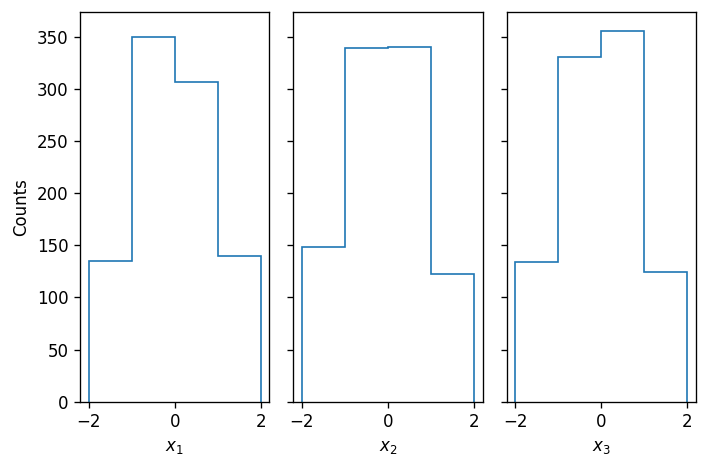

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, dpi=120)
    
axs[0].hist(data.x.values, bins=xbins, histtype="step", label="x_1")
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel("Counts")
axs[1].hist(data.y.values, bins=ybins, histtype="step", label="x_2")
axs[1].set_xlabel(r"$x_2$")
axs[2].hist(data.z.values, bins=zbins, histtype="step", label="x_3")
axs[2].set_xlabel(r"$x_3$")

plt.tight_layout()
plt.savefig("BootstrapMinimalExampleMargins.pdf")
plt.show()
plt.close()

In [16]:
bootstrap_yields = []
data["weights"]=1
for _ in range(10000):
    #sample = data.sample(n=scipy.stats.poisson.rvs(mu=len(data)), replace=True)
    sample = data.sample(n=len(data), replace=True)
    #sample = data
    #sample["weights"] = scipy.stats.poisson.rvs(mu=1,size=len(data))
    #sample["weights"] /= sample["weights"].mean()
    sample["x_bin"] = pd.cut(data.x, xbins, labels=False)
    sample["y_bin"] = pd.cut(data.y, ybins, labels=False)
    sample["z_bin"] = pd.cut(data.z, zbins, labels=False)
    
    bootstrap_yields.append(np.array([
        *sample.groupby("x_bin").weights.sum(),
        *sample.groupby("y_bin").weights.sum(),
        *sample.groupby("z_bin").weights.sum(),
    ]))
    
bootstrap_yields = np.array(bootstrap_yields)


In [17]:
bootstrap_correlation = np.corrcoef(bootstrap_yields, rowvar=False)
bootstrap_correlation

array([[ 1.        , -0.29521998, -0.2562865 , -0.15630252,  0.15917731,
         0.11591032, -0.15198065, -0.12190097, -0.07803352, -0.07733296,
         0.03224915,  0.10735222],
       [-0.29521998,  1.        , -0.48217154, -0.29893398,  0.12149278,
         0.05343199, -0.03158722, -0.13620307, -0.05893078, -0.00352743,
         0.00433585,  0.05549426],
       [-0.2562865 , -0.48217154,  1.        , -0.2778476 , -0.14691041,
        -0.01596608,  0.09650777,  0.09266171,  0.0238994 ,  0.0589468 ,
        -0.02345243, -0.0434364 ],
       [-0.15630252, -0.29893398, -0.2778476 ,  1.        , -0.15197572,
        -0.11003172,  0.09357215,  0.16528527,  0.06010132,  0.03131216,
        -0.0229974 , -0.08459296],
       [ 0.15917731,  0.12149278, -0.14691041, -0.15197572,  1.        ,
        -0.30384751, -0.30308904, -0.15029676, -0.03831281,  0.02064004,
        -0.01343519,  0.01282886],
       [ 0.11591032,  0.05343199, -0.01596608, -0.11003172, -0.30384751,
         1.        , -

In [18]:
%%time

def function(x, y, z):
    return scipy.stats.multivariate_normal.pdf(np.array([x, y, z]), mean=mean, cov=cov)

exact_correlation = np.zeros(bootstrap_correlation.shape)
dim = exact_correlation.shape[0] // 3

for i, xbin in enumerate(zip(xbins, xbins[1:])):
    
    for j, ybin in enumerate(zip(ybins, ybins[1:])):
        nx = scipy.integrate.nquad(function, 
                                   (
                                       xbin, 
                                       (ybins[0], ybins[-1]),
                                       (zbins[0], zbins[-1]),
                                   ))[0]
        ny = scipy.integrate.nquad(function, 
                                   (
                                       (xbins[0], xbins[-1]),
                                       ybin, 
                                       (zbins[0], zbins[-1]),
                                   ))[0]
        nxy = scipy.integrate.nquad(function, 
                                    (
                                        xbin, 
                                        ybin, 
                                        (zbins[0], zbins[-1]),
                                    ))[0]
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i, j+dim] = r
        
    for j, zbin in enumerate(zip(zbins, zbins[1:])):
        nx = scipy.integrate.nquad(function, 
                                   (
                                       xbin, 
                                       (ybins[0], ybins[-1]),
                                       (zbins[0], zbins[-1]),
                                   ))[0]
        ny = scipy.integrate.nquad(function, 
                                   (
                                       (xbins[0], xbins[-1]),
                                       (ybins[0], ybins[-1]),
                                       zbin,
                                   ))[0]
        nxy = scipy.integrate.nquad(function, 
                                    (
                                        xbin, 
                                        (ybins[0], ybins[-1]),
                                        zbin,
                                    ))[0]
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i, j+2*dim] = r

for i, ybin in enumerate(zip(ybins, ybins[1:])):
        
    for j, zbin in enumerate(zip(zbins, zbins[1:])):
        nx = scipy.integrate.nquad(function, 
                                   (
                                       (xbins[0], xbins[-1]),
                                       ybin,
                                       (zbins[0], zbins[-1]),
                                   ))[0]
        ny = scipy.integrate.nquad(function, 
                                   (
                                       (xbins[0], xbins[-1]),
                                       (ybins[0], ybins[-1]),
                                       zbin,
                                   ))[0]
        nxy = scipy.integrate.nquad(function, 
                                    (
                                        (xbins[0], xbins[-1]),
                                        ybin,
                                        zbin,
                                    ))[0]
        r = nxy / nx**0.5 / ny**0.5
        exact_correlation[i+dim, j+2*dim] = r
        
exact_correlation = exact_correlation + exact_correlation.transpose() + np.identity(bootstrap_correlation.shape[0])

CPU times: user 4min 31s, sys: 3.6 s, total: 4min 35s
Wall time: 4min 31s


/tmp/ipykernel_31935/3525377712.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


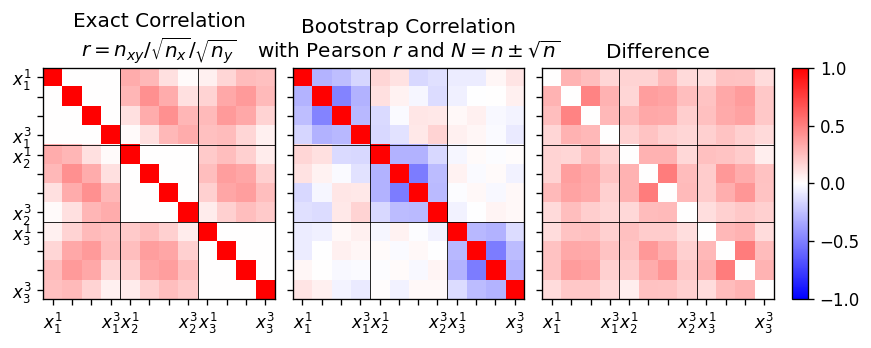

In [19]:
from mpl_toolkits.axes_grid1 import ImageGrid

dim = bootstrap_correlation.shape[0]
vmin = min(np.min(bootstrap_correlation - np.identity(dim)), np.min(exact_correlation - np.identity(dim)))
vmax = max(np.max(bootstrap_correlation - np.identity(dim)), np.max(exact_correlation - np.identity(dim)))

vmax = max(abs(vmin), abs(vmax))
vmin = -vmax

vmin = -1
vmax = 1

fig = plt.figure(figsize=(9.75, 3), dpi=120)

axs = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
    
#axs[0].imshow(exact_correlation - np.identity(dim), vmin=vmin, vmax=vmax, cmap="bwr")
axs[0].imshow(exact_correlation, vmin=vmin, vmax=vmax, cmap="bwr")
axs[0].set_title(f"Exact Correlation\n" + r"$r = n_{xy} / \sqrt{n_x} / \sqrt{n_y}$")
axs[0].set_xticks(range(12))
axs[0].set_xticklabels([r"$x_1^1$", "", "", r"$x_1^3$", r"$x_2^1$", "", "",  r"$x_2^3$", r"$x_3^1$", "", "",  r"$x_3^3$"])
axs[0].set_yticks(range(12))
axs[0].set_yticklabels([r"$x_1^1$", "", "", r"$x_1^3$", r"$x_2^1$", "", "",  r"$x_2^3$", r"$x_3^1$", "", "",  r"$x_3^3$"])
axs[0].axvline(3.5, color="black", lw=0.5)
axs[0].axvline(7.5, color="black", lw=0.5)
axs[0].axhline(3.5, color="black", lw=0.5)
axs[0].axhline(7.5, color="black", lw=0.5)

#axs[1].imshow(bootstrap_correlation - np.identity(dim), vmin=vmin, vmax=vmax, cmap="bwr")
axs[1].imshow(bootstrap_correlation, vmin=vmin, vmax=vmax, cmap="bwr")
axs[1].set_title("Bootstrap Correlation\n" + r"with Pearson $r$ and $N=n\pm\sqrt{n}$")
axs[1].axvline(3.5, color="black", lw=0.5)
axs[1].axvline(7.5, color="black", lw=0.5)
axs[1].axhline(3.5, color="black", lw=0.5)
axs[1].axhline(7.5, color="black", lw=0.5)

im = axs[2].imshow(exact_correlation - bootstrap_correlation, vmin=vmin, vmax=vmax, cmap="bwr")
axs[2].set_title(f"Difference")
axs[2].axvline(3.5, color="black", lw=0.5)
axs[2].axvline(7.5, color="black", lw=0.5)
axs[2].axhline(3.5, color="black", lw=0.5)
axs[2].axhline(7.5, color="black", lw=0.5)

axs[-1].cax.colorbar(im)
axs[-1].cax.toggle_label(True)

plt.tight_layout()
plt.savefig("BootstrapMinimalExampleCorrelation.pdf")
plt.show()
plt.close()

In [20]:
bootstrap_correlation[0:4, 0:4]

array([[ 1.        , -0.29521998, -0.2562865 , -0.15630252],
       [-0.29521998,  1.        , -0.48217154, -0.29893398],
       [-0.2562865 , -0.48217154,  1.        , -0.2778476 ],
       [-0.15630252, -0.29893398, -0.2778476 ,  1.        ]])

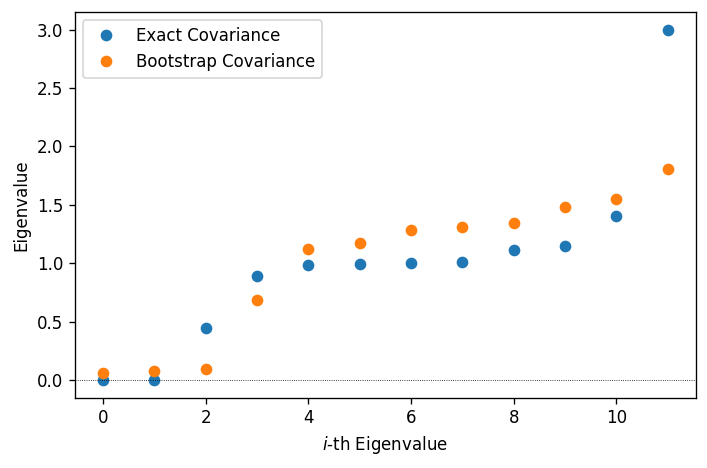

In [21]:
fig = plt.figure(dpi=120)

plt.plot(range(exact_correlation.shape[0]), sorted(np.linalg.eigvals(exact_correlation)), ls="", marker="o", label="Exact Covariance")
plt.plot(range(bootstrap_correlation.shape[0]), sorted(np.linalg.eigvals(bootstrap_correlation)), ls="", marker="o", label="Bootstrap Covariance")
plt.axhline(0, color="black", lw=0.5, ls=":")
plt.xlabel(r"$i$-th Eigenvalue")
plt.ylabel(r"Eigenvalue")
plt.legend()
plt.tight_layout()
plt.savefig("BootstrapMinimalExampleEigenvalues.pdf")
plt.show()
plt.close()